# Coding for Economists - Advanced Session 2

## 1. Setup Environment

In [13]:
%pip install tensorflow scikeras torch dash dash-cytoscape

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 21.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for dash-cytoscape: filename=dash_cytoscape-1.0.2-py3-none-any.whl size=4010717 sha256=f61a32fde8d2edf2fe3e0e8bd2dfc16bc717e31847dee9a6144e64ced7dacf83
  Stored in directory: /Users/jiancao/Library/Caches/pip/wheels/0c/db/f6/9dcb225e9adf45dfef713542769556b1f508170a0759053892
Successfully built dash-cytoscape
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from scikeras.wrappers import KerasRegressor
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Use LSTM to Forecast US Inflation

### 2.1 Collect Data

In [3]:
# Fetch multiple FRED series
start_date = '1990-01-01'
cpi = pdr.DataReader('CPIAUCSL', 'fred', start=start_date)
unrate = pdr.DataReader('UNRATE', 'fred', start=start_date)
fedfunds = pdr.DataReader('FEDFUNDS', 'fred', start=start_date)
print(cpi.shape)
print(unrate.shape)
print(fedfunds.shape)

(423, 1)
(423, 1)
(423, 1)


In [4]:
# Merge features and compute year-on-year inflation
df = cpi.join([unrate, fedfunds]).dropna().rename(columns={
    'CPIAUCSL': 'CPI', 'UNRATE': 'Unemployment', 'FEDFUNDS': 'FedFunds'
})
df['Inflation'] = df['CPI'].pct_change(12) * 100
df = df.dropna()
df.head()

,CPI,Unemployment,FedFunds,Inflation
DATE,,,,
1991-01-01,134.7,6.4,6.91,5.647059
1991-02-01,134.8,6.6,6.25,5.312500
1991-03-01,134.8,6.8,6.12,4.821151
1991-04-01,135.1,6.7,5.91,4.809930
1991-05-01,135.6,6.9,5.78,5.034857


### 2.2 Preprocessing

In [5]:
# Scale variables using Minmax
features = df[['Inflation', 'Unemployment', 'FedFunds']].values
scaler = MinMaxScaler()
scaled = scaler.fit_transform(features)

In [6]:
# Prepare input data for LSTM
def create_sequences(data, seq_len=12):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len, 0])
    return np.array(X), np.array(y)

SEQ_LEN = 12 # use the past 12 months to predict the next month
X, y = create_sequences(scaled, SEQ_LEN)
print(X.shape)
print(y.shape)

(399, 12, 3)
(399,)


### 2.3 Prepare Train/Test Sets

In [7]:
# Train/test split (80/20)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

### 2.4 Implement ISTM and Tune the Parameters

#### Initiate the Model

In [29]:
# Model-building function for GridSearch
def build_model(units=50, optimizer='adam'):
    m = Sequential([
        Input(shape=(SEQ_LEN, X.shape[2])),
        LSTM(units),
        Dense(1)
    ])
    m.compile(optimizer=optimizer, loss='mse')
    return m

# Wrap with KerasRegressor
regressor = KerasRegressor(model=build_model, verbose=0, units=50)

# Grid of hyperparameters
param_grid = {
    'optimizer': ['adam', 'rmsprop'],
    'batch_size': [8, 16],
    'epochs': [30, 40]
}

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

#### Grid Search

In [30]:
# Grid search
grid = GridSearchCV(
    estimator=regressor,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=1
)
grid_result = grid.fit(X_train, y_train)

print("Best MSE: {:.4f}".format(-grid_result.best_score_))
print("Best Params:", grid_result.best_params_)

Best MSE: 0.0049
Best Params: {'batch_size': 8, 'epochs': 40, 'optimizer': 'adam'}


### 2.5 Predict the Historical Inflation

In [33]:
# Select the best model
best_keras_model = grid_result.best_estimator_.model_

# Predict on every available sequence in the data
hist_preds_scaled = best_keras_model.predict(X)

# Inverse‐transform back to % inflation
hist_preds = scaler.inverse_transform(
    np.hstack([
        hist_preds_scaled.reshape(-1, 1),
        np.zeros((len(hist_preds_scaled), 2))
    ])
)[:, 0]  # get the inflation column

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


### 2.6 Forecast the Future 12 Months

In [34]:
# Forecast next 12 months
n_future = 12
last_seq = scaled[-SEQ_LEN:].copy()
future_preds_scaled = []

for _ in range(n_future):
    p = best_keras_model.predict(last_seq.reshape(1, SEQ_LEN, X.shape[2]))[0, 0]
    future_preds_scaled.append([p, last_seq[-1,1], last_seq[-1,2]])  # keep other features static
    last_seq = np.vstack([last_seq[1:], future_preds_scaled[-1]])

# extract inflation forecasts and inverse scale
future_preds = np.array(future_preds_scaled)[:, 0].reshape(-1, 1)
inflation_preds = scaler.inverse_transform(
    np.hstack([future_preds, np.zeros((n_future, 2))])
)[:, 0]

future_dates = pd.date_range(df.index[-1], periods=n_future, freq='ME')
forecast_series = pd.Series(inflation_preds, index=future_dates)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


### 2.7 Plot the Results

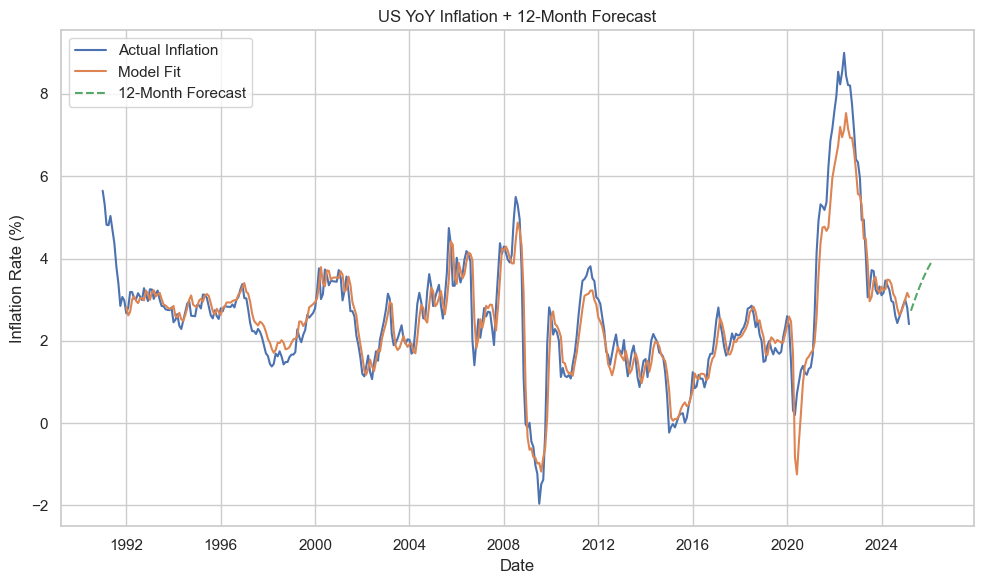

In [35]:
hist_dates = df.index[SEQ_LEN:]
historical = df['Inflation'].copy()

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Actual historical inflation
sns.lineplot(x=historical.index, y=historical.values, label='Actual Inflation')

# Model’s in‐sample fit
sns.lineplot(x=hist_dates, y=hist_preds, label='Model Fit')

# 12‐month out‐of‐sample forecast (as before)
sns.lineplot(
    x=forecast_series.index,
    y=forecast_series.values,
    label='12-Month Forecast',
    linestyle='--'
)

plt.title("US YoY Inflation + 12-Month Forecast")
plt.xlabel("Date")
plt.ylabel("Inflation Rate (%)")
plt.legend()
plt.tight_layout()
plt.show()

## 3. Use GNN to Build Network of Industries

In [1]:
import pandas as pd
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

In [2]:
# Load an I/O matrix: rows = suppliers, cols = customers
io = pd.read_csv("BEA_IO_Accounts.csv", index_col=0, dtype=str, na_values=['---'])
io = io.astype(float)

# Load growth data
df_growth = pd.read_csv("BEA_Industry_Growth.csv", index_col=0)

# Keep common index
common_index = io.index.intersection(df_growth.index)
io     = io.loc[common_index, common_index]
df_growth = df_growth.loc[common_index]

io.head()

,Farms,"Forestry, fishing, and related activities",Oil and gas extraction,"Mining, except oil and gas",Support activities for mining,Utilities,Construction,Wood products,Nonmetallic mineral products,Primary metals,...,Educational services,Ambulatory health care services,Hospitals,Nursing and residential care facilities,Social assistance,"Performing arts, spectator sports, museums, and related activities","Amusements, gambling, and recreation industries",Accommodation,Food services and drinking places,"Other services, except government"
Farms,149222.0,183.0,NaN,45.0,21.0,NaN,3837.0,NaN,NaN,NaN,...,261.0,NaN,NaN,NaN,NaN,NaN,491.0,87.0,8378.0,13.0
"Forestry, fishing, and related activities",27934.0,9440.0,NaN,145.0,NaN,NaN,NaN,22506.0,1.0,NaN,...,63.0,NaN,NaN,NaN,NaN,NaN,404.0,438.0,7764.0,112.0
Oil and gas extraction,NaN,NaN,30944.0,11.0,83.0,29608.0,NaN,25.0,5.0,10.0,...,1291.0,42.0,8.0,18.0,38.0,17.0,232.0,31.0,19.0,161.0
"Mining, except oil and gas",1835.0,0.0,122.0,10397.0,159.0,9288.0,32790.0,10.0,16247.0,21470.0,...,655.0,NaN,27.0,42.0,475.0,474.0,951.0,168.0,1320.0,1639.0
Support activities for mining,NaN,NaN,21084.0,2085.0,1583.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df_growth.head()

,Growth23,Growth24
Farms,-8.1,-10.5
"Forestry, fishing, and related activities",7.7,-4.9
Oil and gas extraction,-19.4,-6.0
"Mining, except oil and gas",6.1,1.1
Support activities for mining,13.5,-4.8


In [4]:
# Build edge list & weights
edges = []
weights = []
for i, supplier in enumerate(io.index):
    for j, customer in enumerate(io.columns):
        val = io.iloc[i, j]
        if val > 0:
            edges.append((i, j))
            weights.append(val)

edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()  # shape [2, E]
edge_attr  = torch.tensor(weights, dtype=torch.float).unsqueeze(1)   # [E,1]

In [5]:
# Node features: last-year’s value-added growth 
x = torch.tensor(df_growth.Growth23.values.reshape(-1,1), dtype=torch.float)

# Target: this year’s growth
y = torch.tensor(df_growth.Growth24.values, dtype=torch.float)

In [6]:
data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)

In [7]:
# Define a two–layer GCN
class IO_GCN(torch.nn.Module):
    def __init__(self, in_feats, hidden=16):
        super().__init__()
        self.conv1 = GCNConv(in_feats, hidden)
        self.conv2 = GCNConv(hidden, 1)
    def forward(self, data):
        h = F.relu(self.conv1(data.x, data.edge_index, data.edge_attr))
        h = self.conv2(h, data.edge_index, data.edge_attr).squeeze()
        return h

model = IO_GCN(in_feats=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn   = torch.nn.MSELoss()

In [8]:
# Train/test split (e.g. 80/20 on nodes)
num_nodes = data.num_nodes
perm = torch.randperm(num_nodes)
train_idx = perm[:int(0.8*num_nodes)]
test_idx  = perm[int(0.8*num_nodes):]

In [9]:
# 8) Training loop
for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = loss_fn(out[train_idx], data.y[train_idx])
    loss.backward()
    optimizer.step()
    if epoch%50==0:
        print(f"Epoch {epoch:03d}  Loss: {loss.item():.4f}")

Epoch 000  Loss: 75.5293
Epoch 050  Loss: 30.2665
Epoch 100  Loss: 29.5497
Epoch 150  Loss: 28.9060
Epoch 200  Loss: 27.6876
Epoch 250  Loss: 26.5528
Epoch 300  Loss: 25.7917
Epoch 350  Loss: 25.3200
Epoch 400  Loss: 24.9953
Epoch 450  Loss: 24.7467
Epoch 500  Loss: 24.5845
Epoch 550  Loss: 24.4647
Epoch 600  Loss: 24.3596
Epoch 650  Loss: 24.2714
Epoch 700  Loss: 24.1917
Epoch 750  Loss: 24.1104
Epoch 800  Loss: 23.9959
Epoch 850  Loss: 23.8566
Epoch 900  Loss: 23.6895
Epoch 950  Loss: 23.5268


In [10]:
# Evaluate
model.eval()
preds = model(data).detach()
mse = loss_fn(preds[test_idx], data.y[test_idx])
print(f"\nTest MSE: {mse:.4f}")


Test MSE: 24.6644


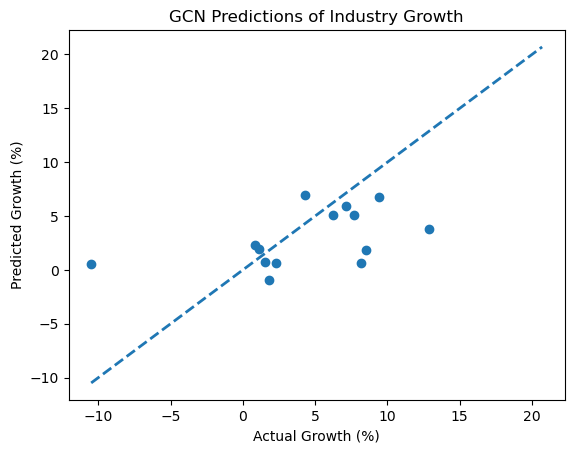

In [11]:
import matplotlib.pyplot as plt
plt.scatter(data.y[test_idx], preds[test_idx])
plt.plot([data.y.min(), data.y.max()],
         [data.y.min(), data.y.max()], '--', lw=2)
plt.xlabel("Actual Growth (%)")
plt.ylabel("Predicted Growth (%)")
plt.title("GCN Predictions of Industry Growth")
plt.show()

In [17]:
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

# 1. Convert to a NetworkX graph
G = to_networkx(
    data,
    node_attrs=[],       
    edge_attrs=[],
    to_undirected=True    
)

edge_index = data.edge_index.t().tolist() 
weights     = data.edge_attr.squeeze().tolist()
for (u, v), w in zip(edge_index, weights):
    G[u][v]['weight'] = float(w)   

In [13]:
# 2. Choose a layout
pos = nx.spring_layout(G, weight='edge_attr', seed=42)

In [35]:
import dash
import dash_cytoscape as cyto
from dash import html
from torch_geometric.utils import to_networkx
import numpy as np

# bConvert to a NetworkX graph
G = to_networkx(
    data,
    node_attrs=[],       
    edge_attrs=[],
    to_undirected=True    
)

edge_index = data.edge_index.t().tolist() 
weights     = data.edge_attr.squeeze().tolist()
for (u, v), w in zip(edge_index, weights):
    G[u][v]['weight'] = float(w)   

# 1. Filter edges: no self-loops, top 10% by weight
all_edges   = [(u, v, d) for u, v, d in G.edges(data=True) if u != v]
all_weights = [d['weight'] for _, _, d in all_edges]
threshold   = np.percentile(all_weights, 98)    # 90th percentile → top 10% flows

important_edges = [
    (u, v, d) for u, v, d in all_edges
    if d['weight'] >= threshold
]

# 2. Build subgraph of just those edges & their nodes
important_nodes = set()
for u, v, _ in important_edges:
    important_nodes.update([u, v])

G_sub = G.subgraph(important_nodes).copy()

# 3. Build Cytoscape “elements” list
elements = []

# nodes
for node in G_sub.nodes():
    elements.append({
        'data': {
            'id': str(node),
            'label': common_index[node]   # map back to industry name
        }
    })

# edges
for u, v, d in important_edges:
    elements.append({
        'data': {
            'source': str(u),
            'target': str(v),
            'weight': d['weight']
        }
    })

# 4. Dash app
app = dash.Dash(__name__)
app.layout = html.Div([
    html.H3("Industry I/O Network (Top 2% Flows, No Self-Loops)"),
    cyto.Cytoscape(
        id='cytoscape-network',
        elements=elements,
        layout={'name': 'cose'},       # force-directed layout
        style={'width': '100%', 'height': '800px'},
        stylesheet=[
            # nodes: wrap truncated label, small font
            {
                'selector': 'node',
                'style': {
                    'content':         'data(label)',
                    'text-wrap':       'wrap',
                    'text-max-width':  80,
                    'font-size':       '8px',
                    'background-color':'#67a9cf',
                    'width':           '20px',
                    'height':          '20px'
                }
            },
            {
                'selector': 'node',
                'style': {
                    'label': 'data(label)',
                    'background-color': '#67a9cf',
                    'width': 20,
                    'height': 20,
                    'font-size': '10px',
                    'text-valign': 'center',
                    'text-halign': 'center'
                }
            },
            {
                'selector': 'edge',
                'style': {
                    # map weight (0→max) to line-width 1→8
                    'width': f"mapData(weight, 0, {max(all_weights)}, 1, 8)",
                    'line-color': '#888',
                    'curve-style': 'bezier'
                }
            }
        ]
    )
])

if __name__ == '__main__':
    app.run(debug=True)


In [30]:
import dash
import dash_cytoscape as cyto
from dash import html
from torch_geometric.utils import to_networkx
import numpy as np

# bConvert to a NetworkX graph
G = to_networkx(
    data,
    node_attrs=[],       
    edge_attrs=[],
    to_undirected=True    
)

edge_index = data.edge_index.t().tolist() 
weights     = data.edge_attr.squeeze().tolist()
for (u, v), w in zip(edge_index, weights):
    G[u][v]['weight'] = float(w)  

# 1. Filter edges as before (no self-loops, top 10% by weight)
all_edges   = [(u, v, d) for u, v, d in G.edges(data=True) if u != v]
all_weights = [d['weight'] for _, _, d in all_edges]
threshold   = np.percentile(all_weights, 98)

important_edges = [
    (u, v, d) for u, v, d in all_edges
    if d['weight'] >= threshold
]

# 2. Build subgraph
important_nodes = set()
for u, v, _ in important_edges:
    important_nodes.update([u, v])
G_sub = G.subgraph(important_nodes).copy()

# 3. Prepare Cytoscape “elements” with both a short label and the full label
elements = []
for node in G_sub.nodes():
    full_label  = common_index[node]
    # truncate to 12 chars + ellipsis
    short_label = (full_label[:12] + "…") if len(full_label) > 12 else full_label
    elements.append({
        'data': {
            'id':       str(node),
            'label':    short_label,
            'full':     full_label
        }
    })

for u, v, d in important_edges:
    elements.append({
        'data': {
            'source': str(u),
            'target': str(v),
            'weight': d['weight']
        }
    })

# 4. Dash + Cytoscape
app = dash.Dash(__name__)
app.layout = html.Div([
    html.H3("Industry I/O Network (Top 10% Flows, No Self-Loops)"),
    cyto.Cytoscape(
        id='cytoscape-net',
        elements=elements,
        # stronger repulsion & longer ideal edge lengths
        layout={
            'name':            'cose',
            'idealEdgeLength': 200,
            'nodeRepulsion':   8000,
            'edgeElasticity':  100,
            'numIter':         1000,
            'gravity':         0.1,
            'tile':            True,
            'tilingPadding':   20
        },
        style={'width': '100%', 'height': '800px'},
        stylesheet=[
            # nodes: wrap truncated label, small font
            {
                'selector': 'node',
                'style': {
                    'content':         'data(label)',
                    'text-wrap':       'wrap',
                    'text-max-width':  80,
                    'font-size':       '8px',
                    'background-color':'#67a9cf',
                    'width':           '20px',
                    'height':          '20px'
                }
            },
            # on hover, show the full name
            {
                'selector': 'node:hover',
                'style': {
                    'content': 'data(full)',
                    'font-size':'10px',
                    'z-index':'10'
                }
            },
            # edges: thickness ~ weight
            {
                'selector': 'edge',
                'style': {
                    'width':          f"mapData(weight, 0, {max(all_weights)}, 1, 6)",
                    'line-color':     '#888',
                    'curve-style':    'bezier',
                    'opacity':        0.6
                }
            }
        ]
    )
])

if __name__ == '__main__':
    app.run(debug=False)


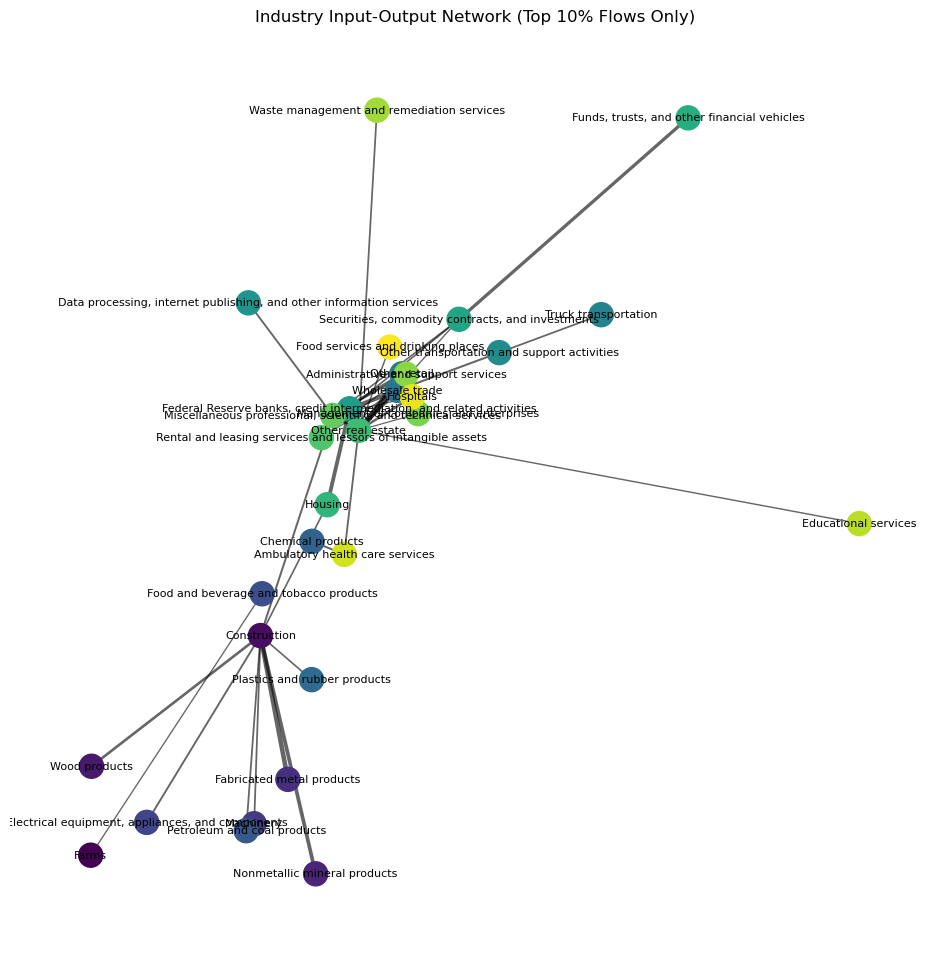

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Filter edges: no self-loops, and top 10% by weight
all_edges = [(u, v, d) for u, v, d in G.edges(data=True) if u != v]
all_weights = [d['weight'] for _, _, d in all_edges]
threshold = np.percentile(all_weights, 98)

important_edges = [
    (u, v, d) for u, v, d in all_edges
    if d['weight'] >= threshold
]

# 2. Build a subgraph with only those edges and their nodes
important_nodes = set()
for u, v, _ in important_edges:
    important_nodes.update([u, v])

G_sub = G.subgraph(important_nodes).copy()

# 3. Layout for subgraph
pos = nx.spring_layout(G_sub, weight='weight', seed=42)

# 4. Draw nodes
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(
    G_sub, pos,
    node_size=300,
    cmap=plt.cm.viridis,
    node_color=range(len(G_sub.nodes))
)

# 5. Draw edges, scaled by weight
edge_weights = [d['weight'] for _, _, d in important_edges]
max_w = max(edge_weights)
widths = [4 * (w / max_w) for w in edge_weights]

nx.draw_networkx_edges(
    G_sub, pos,
    edgelist=[(u, v) for u, v, _ in important_edges],
    width=widths,
    alpha=0.6
)

# 6. Add labels
# Rebuild mapping from node index → industry name if needed
labels = {i: common_index[i] for i in G_sub.nodes}
nx.draw_networkx_labels(G_sub, pos, labels, font_size=8)

plt.title("Industry Input‐Output Network (Top 10% Flows Only)")
plt.axis('off')
plt.show()


In [25]:
from pyvis.network import Network

# 1. Create the PyVis network
net = Network(height="750px", width="100%", directed=True, notebook=False)

# Optional: better physics layout
net.barnes_hut()

# 2. Add nodes with labels
for node in G_sub.nodes:
    net.add_node(
        node,
        label=common_index[node],  # if node IDs map to industry names
        title=f"Industry {common_index[node]}"
    )

# 3. Add edges with tooltips and value-based thickness
for u, v, data in G_sub.edges(data=True):
    weight = data['weight']
    net.add_edge(u, v, value=weight, title=f"{weight:,.1f} units")

# 4. Show the interactive network
net.show("industry_io_network.html")


industry_io_network.html


AttributeError: 'NoneType' object has no attribute 'render'

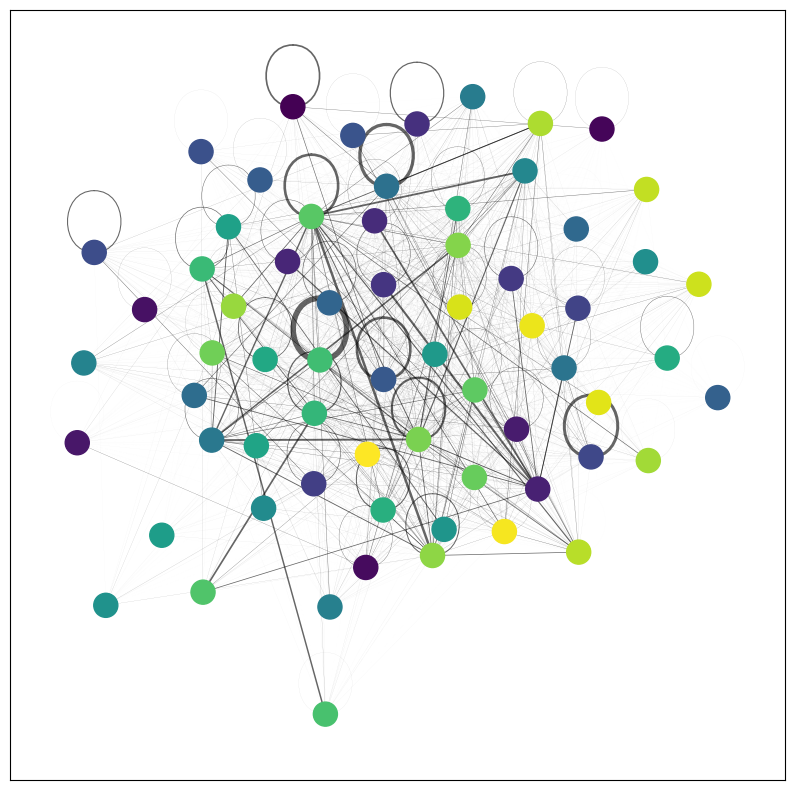

In [20]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(
    G, pos,
    node_size=300,
    cmap=plt.cm.viridis,
    node_color=range(data.num_nodes)  # or some other scalar per node
)

# 4. Draw edges, scaling widths by weight
edge_weights = [d['weight'] for _,_,d in G.edges(data=True)]
# normalize widths to a reasonable range
max_w = max(edge_weights)
widths = [4*(w/max_w) for w in edge_weights]

nx.draw_networkx_edges(
    G, pos,
    width=widths,
    alpha=0.6
)

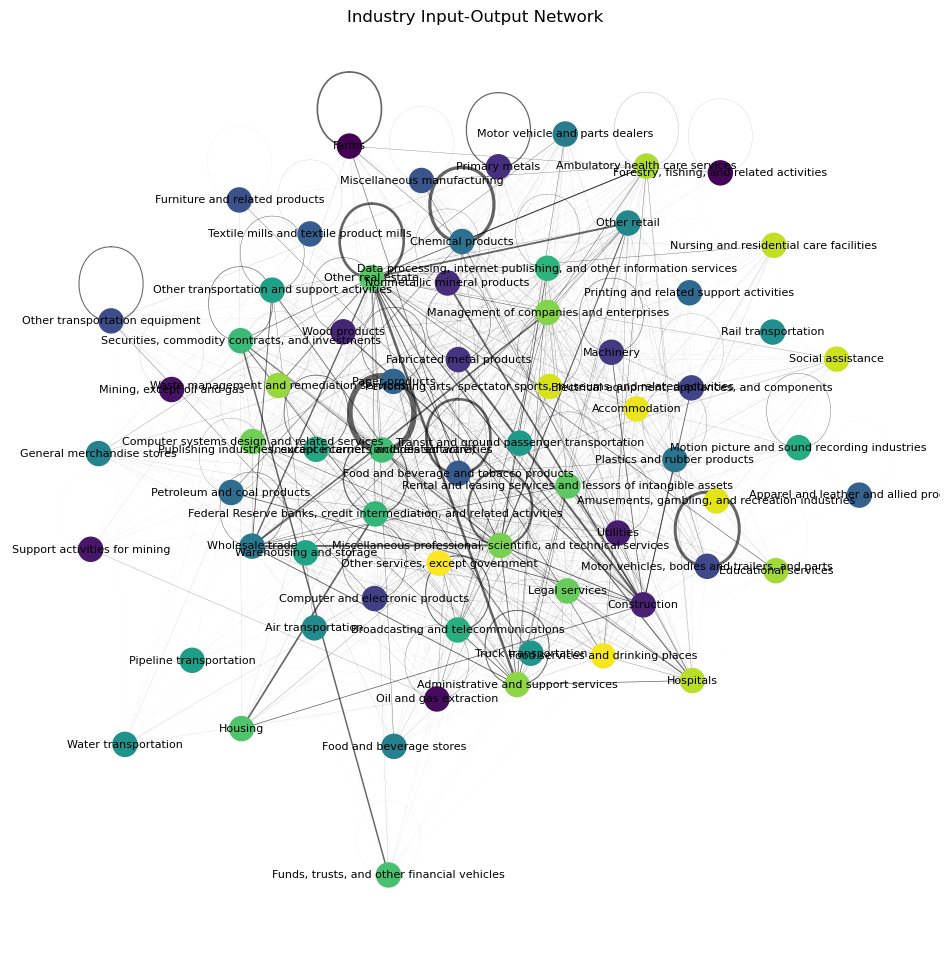

In [21]:
# 3. Draw nodes
plt.figure(figsize=(12,12))
nx.draw_networkx_nodes(
    G, pos,
    node_size=300,
    cmap=plt.cm.viridis,
    node_color=range(data.num_nodes)  # or some other scalar per node
)


# 4. Draw edges, scaling widths by weight
edge_weights = [d['weight'] for _,_,d in G.edges(data=True)]
# normalize widths to a reasonable range
max_w = max(edge_weights)
widths = [4*(w/max_w) for w in edge_weights]

nx.draw_networkx_edges(
    G, pos,
    width=widths,
    alpha=0.6
)


# 5. Add labels
labels = {i: name for i, name in enumerate(common_index)}  # if you kept `common` list
nx.draw_networkx_labels(G, pos, labels, font_size=8)

plt.title("Industry Input‐Output Network")
plt.axis('off')
plt.show()

In [17]:
from pyvis.network import Network

net = Network(height="800px", width="100%", directed=True)
# add nodes
for n in common_index:
    net.add_node(n, label=n)
# add edges above some threshold
for u, v, w in G.edges(data='weight'):
    if w > 1000:
        net.add_edge(common_index[u], common_index[v], value=w)

net.show("industry_io.html")

industry_io.html


AttributeError: 'NoneType' object has no attribute 'render'

ValueError: shape mismatch: value array of shape (1959,1) could not be broadcast to indexing result of shape (1959,)